1. exclude covid window (contiguous before and after covid)
2. interpolate values through covid? (use new dataset/df)
3. train/test split graphs and performance
4. extend feature engineering
5. extend/vary holiday window

- hourly meteostat data
- noaa one stop data
- more weather variables (doc)

# Imports

In [3]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor as lgbm, early_stopping
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from collections import Counter

# Step 1: Data Collection and Preprocessing

## Data Collection

### Import Data

In [4]:
# 17s to run
df = pd.read_csv("FINAL_DATASET.csv")

/var/folders/hb/9n_ph5yj0491qld3nd7lpr900000gn/T/ipykernel_61225/2773073336.py:2: DtypeWarning: Columns (76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("FINAL_DATASET.csv")


### Display Data

In [5]:
df = df.dropna(subset=['WeatherDelay'])
print(df.head())
print("Data Range:")
print(len(df), "rows")
print(df['FlightDate'].iloc[[0, -1]])

    Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
8   2015        3      8           2          7  2015-08-02                WN   
10  2015        3      8           2          7  2015-08-02                WN   
18  2015        3      8           2          7  2015-08-02                WN   
22  2015        3      8           2          7  2015-08-02                WN   
24  2015        3      8           2          7  2015-08-02                WN   

    DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  \
8                      19393                          WN      N7725A   
10                     19393                          WN      N933WN   
18                     19393                          WN      N480WN   
22                     19393                          WN      N366SW   
24                     19393                          WN      N378SW   

    Flight_Number_Reporting_Airline  OriginAirportID  OriginAirportSeqID  \
8   

In [6]:
df_grouped = df.groupby(['Origin', 'Dest', 'Month', 'DayOfWeek']).agg({
    'DepDelayMinutes': 'mean',
    'wspd': 'mean', 'tavg': 'mean', 'tmin': 'mean', 'tmax': 'mean', 'prcp': 'mean', 
    'snow': 'mean', 'wdir': 'mean', 'wspd': 'mean', 'wpgt': 'mean', 'pres': 'mean', 
}).reset_index()


## Data Preprocessing

### Converting to Imperial

In [5]:
# Temperature: Convert °C to °F
for col in ["tavg", "tmin", "tmax"]:
    if col in df.columns:
        df[col] = (df[col] * 9/5 + 32).round().astype("Int64")

# Precipitation & Snow: Convert mm to inches
for col in ["prcp", "snow"]:
    if col in df.columns:
        df[col] = df[col] / 25.4

# Wind Speed: Convert km/h to mph
if "wspd" in df.columns:
    df["wspd"] = df["wspd"] / 1.60934

# Pressure: Convert hPa to inHg
if "pres" in df.columns:
    df["pres"] = df["pres"] * 0.02953

print(df.head(1))

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19393                          WN      N7743B  ...   

   tavg  tmin  tmax  prcp snow wdir       wspd  wpgt       pres  tsun  
0    81    71    94   0.0  0.0  NaN  10.501199   NaN  29.828253   NaN  

[1 rows x 120 columns]


### Treating Missing Values

In [6]:
# Percentage NA by column
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False).head(75))

# Removing >3% missing cols and IATA Code column due to redundancy
cols_to_drop = percent_na[percent_na > 3].index
df = df.drop(columns = cols_to_drop)

print(f"\nDropped {len(cols_to_drop)} columns")
print("Remaining columns: ", len(df.columns))

# Printing percentage again
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

# Drop NaN rows
df.dropna(inplace=True)

Div3Airport             100.000000
Div3AirportSeqID        100.000000
Div3TotalGTime          100.000000
Div3LongestGTime        100.000000
Div3WheelsOff           100.000000
Div3TailNum             100.000000
Div4Airport             100.000000
Div4AirportID           100.000000
Div4AirportSeqID        100.000000
Div4WheelsOn            100.000000
Div4TotalGTime          100.000000
Div4LongestGTime        100.000000
Div4WheelsOff           100.000000
Div4TailNum             100.000000
Div5Airport             100.000000
Div5AirportID           100.000000
Div5AirportSeqID        100.000000
Div5WheelsOn            100.000000
Div5TotalGTime          100.000000
Div5LongestGTime        100.000000
Div5WheelsOff           100.000000
Div5TailNum             100.000000
Unnamed: 109            100.000000
wdir                    100.000000
Div3AirportID           100.000000
Div3WheelsOn            100.000000
tsun                     99.999711
Div2TailNum              99.999578
Div2WheelsOff       

### Heatmap After Removing Highly Correlated and Unwanted Variables

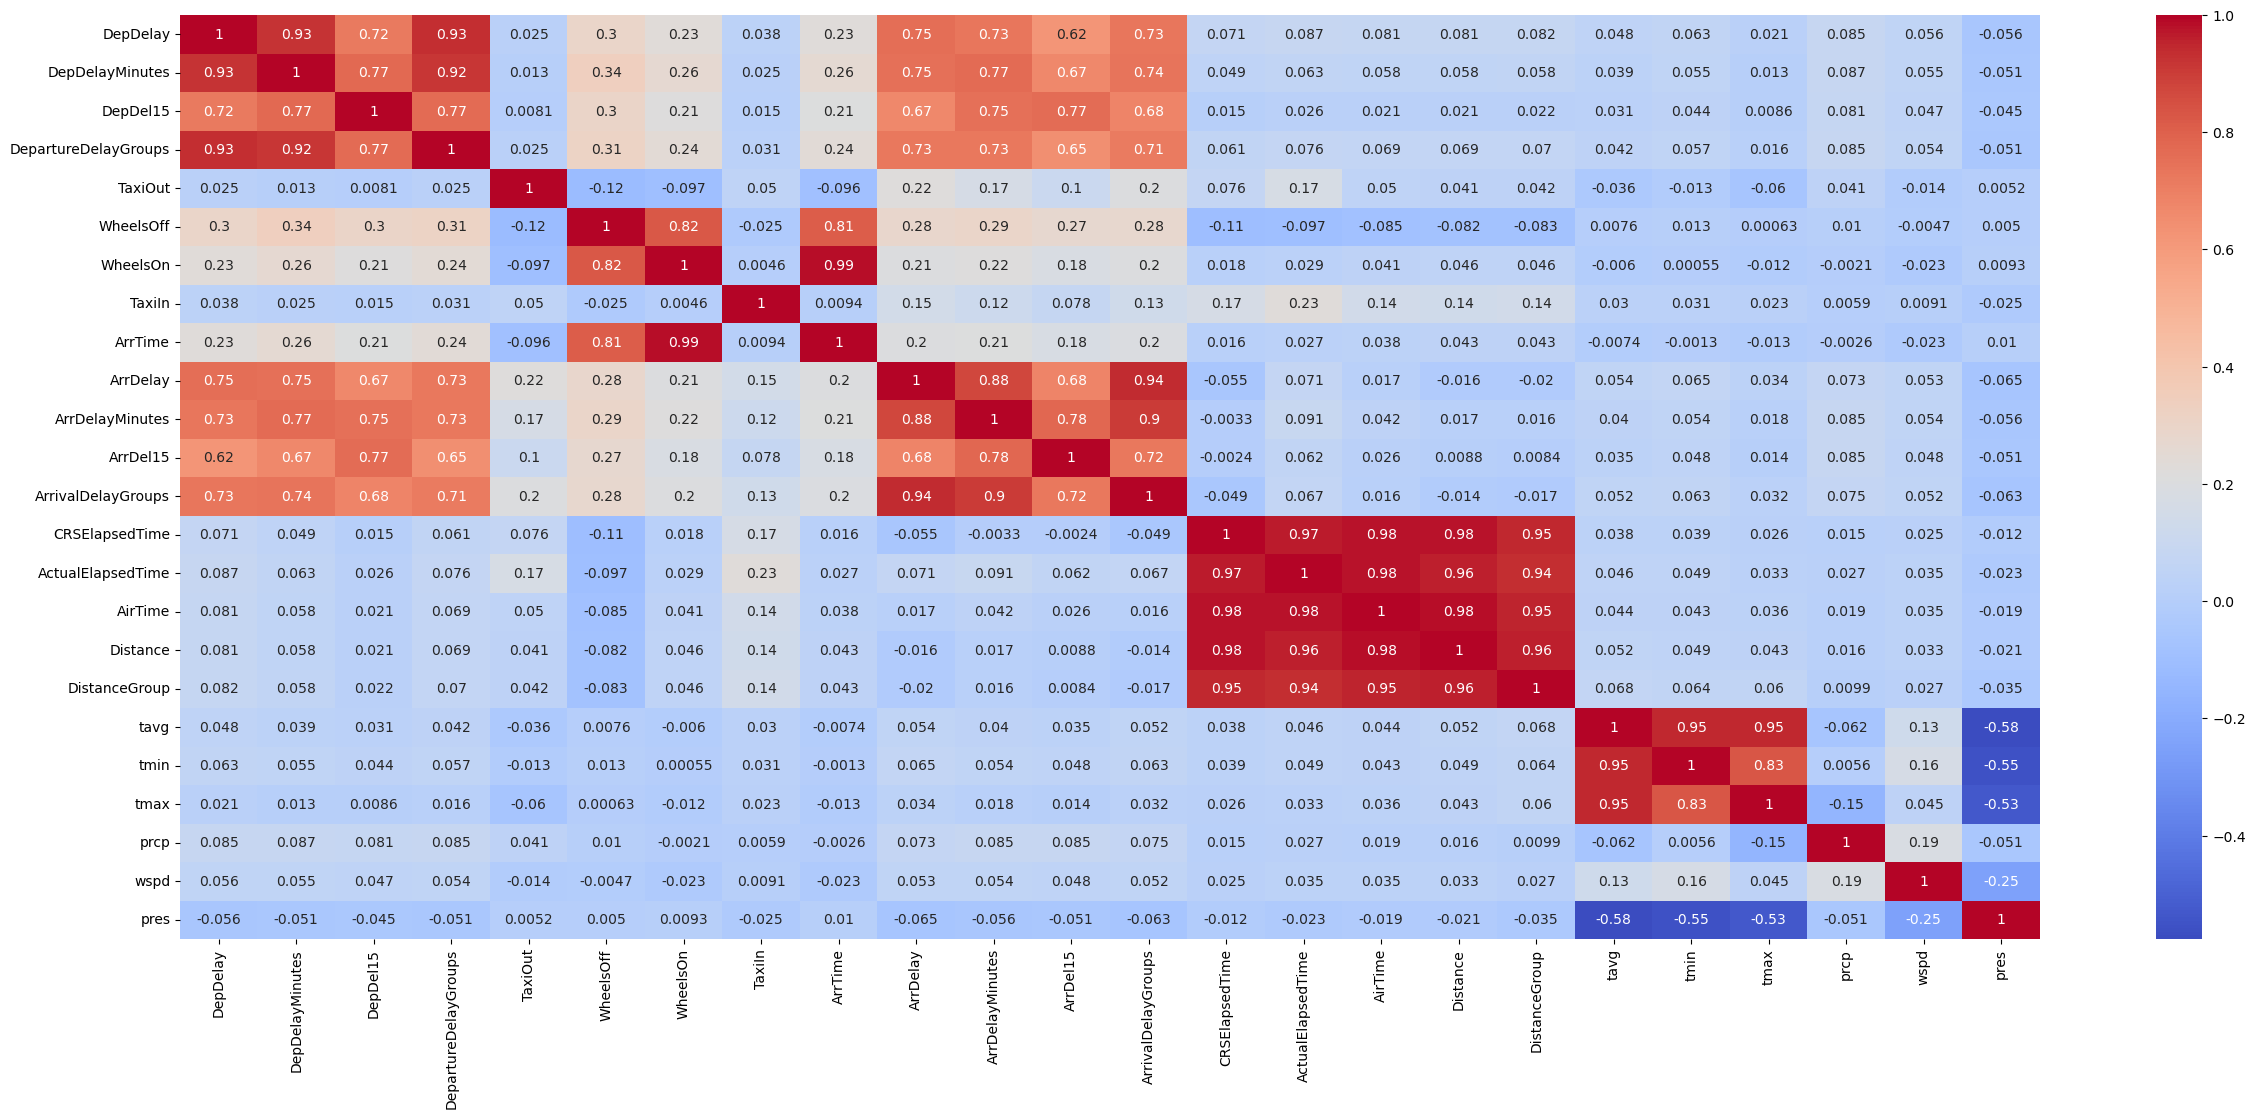

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# df = df.drop(columns = ['Tail_Number', 'ArrDel15', 'DepDelay', 'WheelsOn', 'WheelsOff', 'TaxiIn', 'TaxiOut', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrivalDelayGroups', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DistanceGroup'])
# df = df.drop(columns = ['DepDel15', 'DepartureDelayGroups'])
numeric_df = df.select_dtypes(include = ['number']).drop(columns = ['DepTime', 'Year', 'Quarter', 'DayofMonth', 'DivAirportLandings', 'DestAirportSeqID', 'Flights', 'OriginAirportID', 'OriginStateFips', 'DestWac', 'OriginWac', 'CRSDepTime', 'CRSArrTime', 'Cancelled', 'DestStateFips', 'DayOfWeek', 'Month', 'DOT_ID_Reporting_Airline', 'Flight_Number_Reporting_Airline', 'OriginCityMarketID', 'Diverted', 'OriginAirportSeqID', 'DestAirportID', 'DestCityMarketID'], errors = 'ignore')
plt.figure(figsize = (30, 12))
sns.heatmap(numeric_df.corr(method='spearman'), annot = True, cmap = "coolwarm")
plt.show()

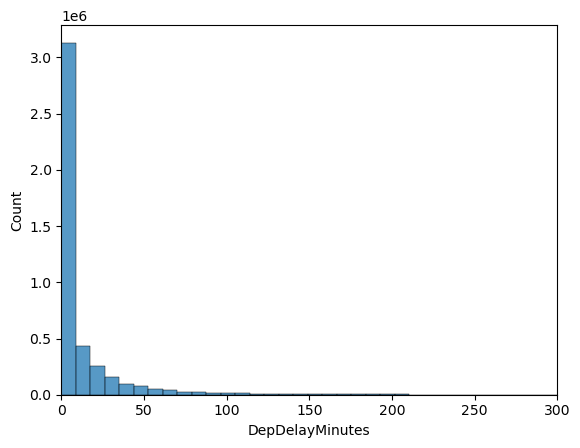

In [13]:
sns.histplot(df['DepDelayMinutes'], bins=100)
plt.xlim(0, 300)
plt.show()

The extreme right skew, combined with the low correlation coefficients, indicates we need to perform some feature engineering to help the model find relations between weather data and delay lengths.

In [14]:
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

DepTime                            1.899147
DepDelayMinutes                    1.899147
DepDel15                           1.899147
DepartureDelayGroups               1.899147
prcp                               0.458100
pres                               0.073344
tmax                               0.008974
tmin                               0.008974
wspd                               0.000844
tavg                               0.000244
DepTimeBlk                         0.000000
DestStateName                      0.000000
DestWac                            0.000000
CRSDepTime                         0.000000
Cancelled                          0.000000
CRSArrTime                         0.000000
ArrTimeBlk                         0.000000
Quarter                            0.000000
Diverted                           0.000000
Flights                            0.000000
Distance                           0.000000
DivAirportLandings                 0.000000
DestStateFips                   

### Delays Over Time

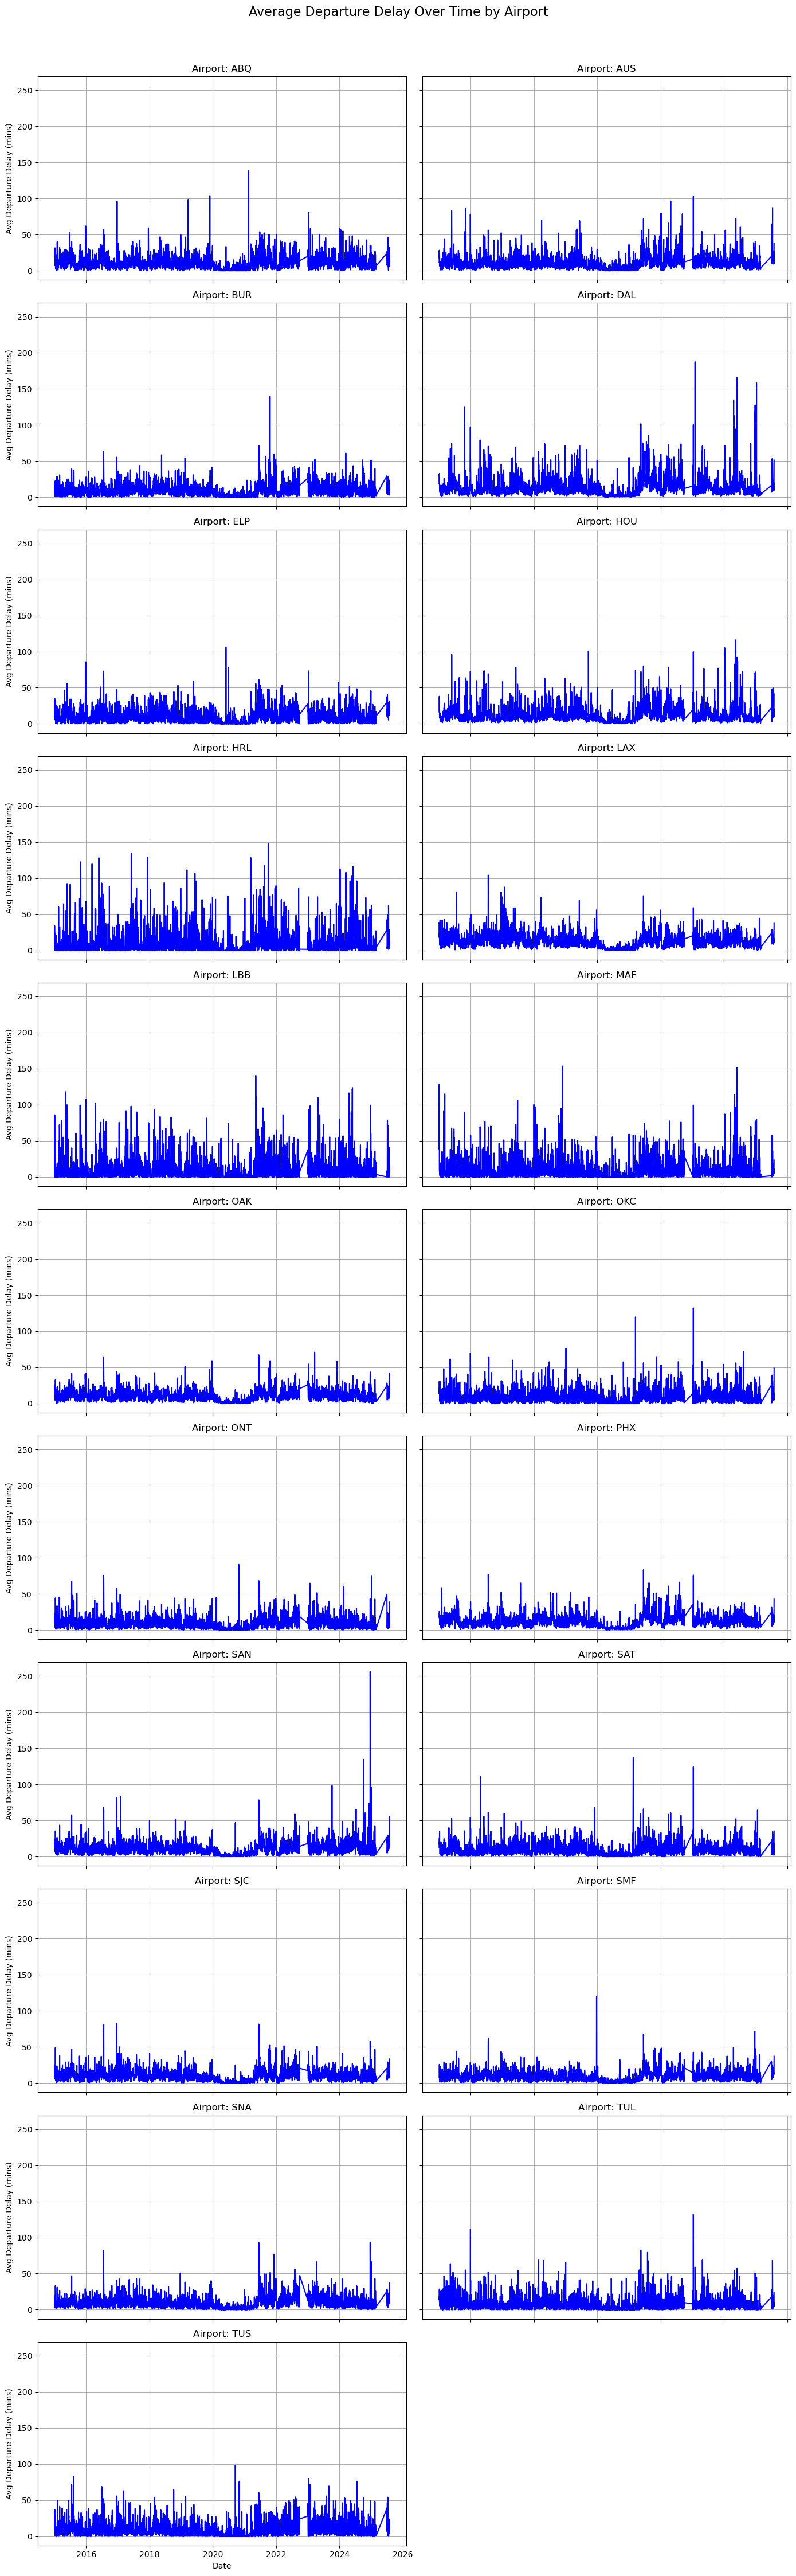

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date column is datetime
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# ------------------------
# 2️⃣ Aggregate: average delay per day per airport
# ------------------------
avg_delay = (
    df.groupby(['FlightDate', 'Origin'])['DepDelayMinutes']
      .mean()
      .reset_index()
)

# ------------------------
# 3️⃣ Get unique airports
# ------------------------
airports = avg_delay['Origin'].unique()
num_airports = len(airports)

# ------------------------
# 4️⃣ Create subplots (one per airport)
# ------------------------
# Calculate number of rows and columns for subplots
cols = 2  # Adjust if you want more columns
rows = (num_airports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index

# Plot each airport
for i, airport in enumerate(airports):
    airport_data = avg_delay[avg_delay['Origin'] == airport]
    sns.lineplot(
        data=airport_data,
        x='FlightDate',
        y='DepDelayMinutes',
        ax=axes[i],
        color='blue'
    )
    axes[i].set_title(f"Airport: {airport}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Avg Departure Delay (mins)")
    axes[i].grid(True)

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Average Departure Delay Over Time by Airport", y=1.02, fontsize=16)
plt.show()


### Transform Target

Log Transformation

In [110]:
df['DepDelayMinutes_log'] = np.log1p(df['DepDelayMinutes'])

Box-Cox Transformation

In [115]:
df['DepDelay_shifted'] = df['DepDelayMinutes'] + 1e-3  # avoid zeros
pt_boxcox = PowerTransformer(method='box-cox', standardize=False)
df['DepDelayMinutes_boxcox'] = pt_boxcox.fit_transform(df['DepDelay_shifted'].values.reshape(-1,1))

Yeo-Johnson Transformation

In [116]:
pt_yeojohnson = PowerTransformer(method='yeo-johnson', standardize=False)
df['DepDelayMinutes_yeojohnson'] = pt_yeojohnson.fit_transform(df['DepDelayMinutes'].values.reshape(-1,1))

## Feature Engineering

### Extra Features

In [7]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# DayOfYear: Day of the year (1-365/366)
df['DayOfYear'] = df['FlightDate'].dt.dayofyear

# IsWeekend: 1 if the flight date is Saturday or Sunday, else 0
df['IsWeekend'] = df['DayOfWeek'].isin([6,7]).astype(int)

# IsHoliday: 1 if the flight date is a US federal holiday, else 0
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['FlightDate'].min(), end=df['FlightDate'].max())
df['IsHoliday'] = df['FlightDate'].isin(holidays)

# IsHolidayWindow: within specified day range of holiday
expanded_holidays = set()

for d in range(25, 32):
    expanded_holidays.add((5, d))   # Memorial Day
for d in range(2, 7):
    expanded_holidays.add((7, d))   # Independence Day
for d in range(1, 8):
    expanded_holidays.add((9, d))   # Labor Day
for d in range(22, 29):
    expanded_holidays.add((11, d))  # Thanksgiving
for d in range(19, 32):
    expanded_holidays.add((12, d))  # Christmas
expanded_holidays.add((1, 1))       # New Year
for d in range(28, 32):
    expanded_holidays.add((3, d))    # Easter
for d in range(1, 3):
    expanded_holidays.add((4, d))    # Easter

df["IsHolidayWindow"] = list(zip(df["Month"], df["DayofMonth"]))
df["IsHolidayWindow"] = df["IsHolidayWindow"].isin(expanded_holidays).astype(int)


# NumDepartures: number of departures from the origin airport on that day
daily_departures = (
    df.groupby(['OriginAirportID', 'FlightDate'])
      .size()
      .rename('NumDepartures')
      .reset_index()
)

df = df.merge(daily_departures, on=['OriginAirportID', 'FlightDate'], how='left')

# Ensure Date column exists and is datetime
df['Date'] = pd.to_datetime(df['FlightDate'])

# Sort so rolling ops are time-consistent
df = df.sort_values(['OriginAirportID', 'Date'])

# RouteDelayMean_7d: Route-level rolling delay mean
df['Route'] = df['OriginAirportID'].astype(str) + '_' + df['DestAirportID'].astype(str)
df['RouteDelayMean_7d'] = (
    df.groupby('Route')['DepDelayMinutes']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).mean())
)

# OriginDelayMean_7d: Airport-level (origin) rolling delay mean
df['OriginDelayMean_7d'] = (
    df.groupby('OriginAirportID')['DepDelayMinutes']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).mean())
)

# DestArrivals_7d: Destination congestion indicator
df['DestArrivals_7d'] = (
    df.groupby('DestAirportID')['Flight_Number_Reporting_Airline']
      .transform(lambda x: x.shift().rolling(7, min_periods=1).count())
)

# Replace any remaining NaN (from shift/rolling) with reasonable defaults
df.fillna({
    'RouteDelayMean_7d': 0,
    'OriginDelayMean_7d': 0,
    'DestArrivals_7d': 0
}, inplace=True)

# Departures_Today: Day-level departure volume (can help with congestion)
df['Departures_Today'] = df.groupby(['OriginAirportID', 'Date'])['Flight_Number_Reporting_Airline'].transform('count')

# Interaction features (useful for nonlinear models like LightGBM)
df['Dist_x_Wspd'] = df['Distance'] * df['wspd']
df['TempRange'] = df['tmax'] - df['tmin']
df['MonthxWeekday'] = df['Month'] * df['DayOfWeek']

# CongestionRatio: Ratio of today's departures to average departures for that airport
df['AvgDepartures_Past30d'] = (
    df.groupby('OriginAirportID')['NumDepartures']
      .transform(lambda x: x.shift().rolling(30, min_periods=1).mean())
)
df['CongestionRatio'] = df['NumDepartures'] / df['AvgDepartures_Past30d']

# OriginDelayTrend_3d: Captures worsening congestion trend
df['OriginDelayTrend_3d'] = df.groupby('OriginAirportID')['OriginDelayMean_7d'].transform(lambda x: x.diff(3))

# DayOfYear cyclical features avoid discontinuity from 12-31 to 01-01
df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear']/365)
df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear']/365)

# HighDelayFlag: binary indicator if delay > 60 mins
df['HighDelayFlag'] = (df['DepDelayMinutes'] > 60).astype(int)



# Step 2: Modeling

### Feature Selection

In [10]:
features = [

    # 'Year', Removing Year to focus on dynamic predictors 
    'Month', 'DayOfWeek', 'Flight_Number_Reporting_Airline',
    'OriginAirportID', 'OriginCityMarketID', 'OriginStateFips',
    'DestAirportID', 'DestCityMarketID', 'DestStateFips',
    'CRSDepTime', 'CRSArrTime', 'Distance', 'tavg', 'tmin', 'tmax',
    'prcp', 'wspd', 'pres', 'IsWeekend', 'IsHoliday', 'IsHolidayWindow',
    'NumDepartures', 'RouteDelayMean_7d', 'OriginDelayMean_7d', 
    'DestArrivals_7d', 'Departures_Today', 'Dist_x_Wspd', 'TempRange',
    'MonthxWeekday', 'AvgDepartures_Past30d', 'OriginDelayTrend_3d',
    'DayOfYear_sin', 'DayOfYear_cos', 'CongestionRatio',
    'HighDelayFlag'
]

tdf = df[features + ['Cancelled']].dropna()

In [15]:
# Define Feature Groups
WEATHER_SEQUENCE_COLS = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']
STATIC_CATEGORICAL_COLS = ['Month', 'DayOfWeek']
STATIC_NUMERIC_COLS = [
    col for col in tdf.columns if col not in WEATHER_SEQUENCE_COLS and col not in STATIC_CATEGORICAL_COLS and col != 'Date' and col != 'Cancelled'
]
TARGET_COL = 'Cancelled' # Assuming the new task is binary classification (e.g., cancellation/delay flag)

# Set the sequence length based on your external data preparation (e.g., 12 steps for a 6-hour window)
SEQUENCE_LENGTH = 12 
N_WEATHER_FEATURES = len(WEATHER_SEQUENCE_COLS)
print(f"Weather Sequence Features: {N_WEATHER_FEATURES} columns.")
print(f"Static Numeric Features: {len(STATIC_NUMERIC_COLS)} columns.")
print(f"Static Categorical Features: {len(STATIC_CATEGORICAL_COLS)} columns (OHE).")

Weather Sequence Features: 6 columns.
Static Numeric Features: 27 columns.
Static Categorical Features: 2 columns (OHE).


### Data Preparation

In [16]:
def create_weather_sequences(df, sequence_cols, seq_length):
    """
    Creates the 3D sequence array for weather data.
    
    This assumes the input DataFrame `df` is already sorted by time/date.
    The sequence for prediction at index 'i' includes data from 'i - seq_length' to 'i - 1'.
    """
    weather_data = df[sequence_cols].values
    X_seq = []
    
    # We start creating sequences after the index required to fill the first sequence
    for i in range(seq_length, len(weather_data)):
        # Append the sequence of length 'seq_length' preceding the current index 'i'
        X_seq.append(weather_data[i-seq_length:i, :])
        
    return np.array(X_seq)

# Create the 3D array of weather sequences
weather_sequences = create_weather_sequences(tdf, WEATHER_SEQUENCE_COLS, SEQUENCE_LENGTH)

# Since the sequence creation drops the first SEQUENCE_LENGTH rows,
# we must align the static features and target variable with the new starting point.
data_aligned = tdf.iloc[SEQUENCE_LENGTH:].copy()

print(f"\n3D Weather Sequence Array shape: {weather_sequences.shape}")
print(f"Aligned Static Data and Target shape: {data_aligned.shape}")


3D Weather Sequence Array shape: (4385332, 12, 6)
Aligned Static Data and Target shape: (4385332, 36)


### Preprocessing & Scaling

In [18]:
# --- 3. PREPROCESSING AND SCALING ---

# 3a. Target Variable and Class Weighting (For Imbalance Handling)
# Use the aligned target variable
y = data_aligned[TARGET_COL].values
counts = Counter(y)
total_samples = len(y)
n_minority = counts[1] if 1 in counts else 1 # Avoid division by zero
n_majority = counts[0] if 0 in counts else total_samples

# Calculate class weights for Imbalance Handling
weight_for_0 = total_samples / (2 * n_majority)
weight_for_1 = total_samples / (2 * n_minority)
class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"\nClass Distribution (Aligned): Canceled (1): {n_minority} ({n_minority/total_samples*100:.2f}%)")
print(f"Calculated Class Weights: {class_weights}")


# 3b. Static Categorical Features (One-Hot Encoding)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
static_categorical_ohe = ohe.fit_transform(data_aligned[STATIC_CATEGORICAL_COLS])
N_CAT_FEATURES = static_categorical_ohe.shape[1]
print(f"One-Hot Encoding created {N_CAT_FEATURES} features.")


# 3c. Static Numerical Features (MinMax Scaling)
static_numeric_data = data_aligned[STATIC_NUMERIC_COLS].values
numeric_scaler = MinMaxScaler()
static_numeric_scaled = numeric_scaler.fit_transform(static_numeric_data)
N_NUM_FEATURES = static_numeric_scaled.shape[1]


# 3d. Weather Sequence Features Scaling (IMPORTANT: Scale the 3D array)
# Scale the features across all samples and timesteps simultaneously
weather_sequences_reshaped = weather_sequences.reshape(-1, N_WEATHER_FEATURES)
weather_scaler = MinMaxScaler()
weather_sequences_scaled_flat = weather_scaler.fit_transform(weather_sequences_reshaped)

# --- FIX: Use the exact number of samples from the sequence array to reshape ---
N_SAMPLES_ALIGNED = weather_sequences.shape[0] 
weather_sequences_scaled = weather_sequences_scaled_flat.reshape(N_SAMPLES_ALIGNED, SEQUENCE_LENGTH, N_WEATHER_FEATURES)


# 3e. Combine Static Features
static_features = np.hstack([static_categorical_ohe, static_numeric_scaled])
N_STATIC_FEATURES = static_features.shape[1]

# --- Alignment Check (New robustness check) ---
if N_SAMPLES_ALIGNED != len(static_features):
    raise ValueError(f"Alignment Error: Sequence samples ({N_SAMPLES_ALIGNED}) must match static samples ({len(static_features)}). Please check data_aligned indexing.")
print(f"Data alignment check passed: {N_SAMPLES_ALIGNED} samples ready for split.")


Class Distribution (Aligned): Canceled (1): 1 (0.00%)
Calculated Class Weights: {0: 0.5, 1: 2192666.0}
One-Hot Encoding created 19 features.
Data alignment check passed: 4385332 samples ready for split.


### Train-Test Split

In [21]:
# Note: X_seq_train, X_seq_test must use weather_sequences_scaled
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    weather_sequences_scaled, static_features, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train/Test split complete. Train samples: {len(y_train)}, Test samples: {len(y_test)}")
print("-" * 50)

Train/Test split complete. Train samples: 3508265, Test samples: 877067
--------------------------------------------------


### Model Construction

In [22]:
def build_hybrid_model(look_back, gru_units, dense_units, dropout_rate, lr, activation):
    # --- Input 1: Sequential (Weather) ---
    seq_input = Input(shape=(look_back, N_WEATHER_FEATURES), name='weather_sequence_input')
    
    # GRU layer to process the time-series data
    x = GRU(gru_units, activation=activation)(seq_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # --- Input 2: Static (Flight Metadata, OHE, Scaled Numerics) ---
    static_input = Input(shape=(N_STATIC_FEATURES,), name='static_features_input')
    
    # Dense layers to process static features
    y = Dense(dense_units, activation='relu')(static_input)
    y = BatchNormalization()(y)
    y = Dropout(dropout_rate)(y)
    
    # --- Merge Inputs ---
    merged = Concatenate()([x, y])
    
    # --- Classification Head ---
    z = Dense(int(dense_units / 2), activation='relu')(merged)
    z = Dropout(dropout_rate)(z)
    
    # Final Output Layer (1 neuron, Sigmoid for probability)
    output = Dense(1, activation='sigmoid', name='cancellation_output')(z)
    
    model = Model(inputs=[seq_input, static_input], outputs=output)
    
    optimizer = Adam(learning_rate=lr)
    # Binary Crossentropy is the standard loss for binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Hyperparameter Tuning

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    look_back = SEQUENCE_LENGTH # Fixed based on data prep
    gru_units = trial.suggest_int("gru_units", 32, 256)
    dense_units = trial.suggest_int("dense_units", 64, 512)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    activation = trial.suggest_categorical("activation", ["tanh", "relu"])
    
    model = build_hybrid_model(look_back, gru_units, dense_units, dropout_rate, lr, activation)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
 
    # Train the model with Class Weights for Imbalance
    model.fit(
        [X_seq_train, X_static_train], y_train, 
        epochs=100, 
        batch_size=batch_size, 
        verbose=0, 
        validation_split=0.1, 
        callbacks=[early_stopping],
        class_weight=class_weights # <--- Applying weights
    )
    
    # Make predictions (probabilities) on the test set
    y_test_pred_proba = model.predict([X_seq_test, X_static_test], verbose=0)
    
    # Compute AUC-ROC: The optimal metric for imbalanced classification
    try:
        auc = roc_auc_score(y_test, y_test_pred_proba)
    except ValueError:
        # Fallback if only one class is present in the prediction
        auc = 0.5 
        
    # Optuna minimizes, so we minimize 1 - AUC to maximize AUC
    return 1.0 - auc

# Run Optuna Study

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30) 

print("\n" + "="*50)
print("Optuna Optimization Results")
print("="*50)
trial = study.best_trial
best_auc = 1.0 - trial.value
print(f"  Best AUC (estimated): {best_auc:.4f}")
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print("="*50)

[I 2025-11-19 16:40:36,166] A new study created in memory with name: no-name-6f84b142-e61f-4bd7-85f2-7f49f8b4450f


### Model Training & Evaluation

In [ ]:
print("\nTraining Final Model...")
best_params = trial.params
look_back = SEQUENCE_LENGTH 

final_model = build_hybrid_model(
    look_back=look_back,
    gru_units=best_params['gru_units'],
    dense_units=best_params['dense_units'],
    dropout_rate=best_params['dropout_rate'],
    lr=best_params['lr'],
    activation=best_params['activation']
)

# Train the final model with best parameters and class weights
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = final_model.fit(
    [X_seq_train, X_static_train], y_train, 
    epochs=100, 
    batch_size=best_params['batch_size'], 
    verbose=1, 
    validation_split=0.1, 
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Prediction on Test Set (Probabilities)
y_pred_proba = final_model.predict([X_seq_test, X_static_test])

# Final Evaluation
final_auc = roc_auc_score(y_test, y_pred_proba)
print("\n" + "="*50)
print("Final Evaluation Metrics on Test Set:")
print(f"  AUC-ROC Score: {final_auc:.4f} (Goal: High value, close to 1.0)")
print("="*50)